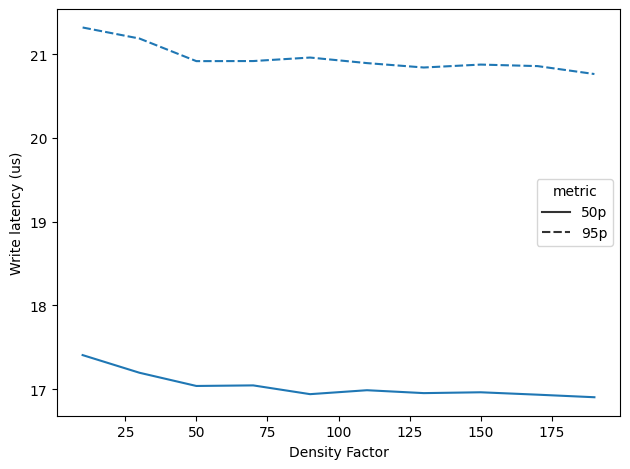

In [2]:
# writes

from numpy import percentile

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run


def measure_density_factor(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': list(range(10, 201, 20)),
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_density_factor], {}
)


data = df[['density_factor', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000

# keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, memtable_bytes_limit: 10K, 10second sample for each average latency measurement
lineplot(data=data, x='density_factor', y='value', style='metric',
         filename='density_factor_write.pdf', xlabel='Density Factor',
         ylabel='Write latency (us)')

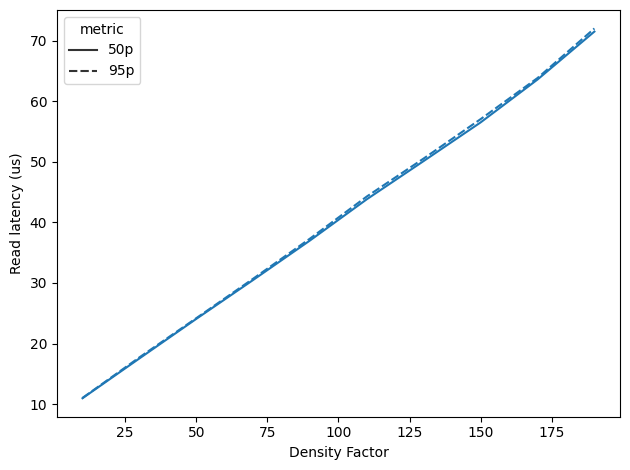

In [4]:
# reads

from numpy import percentile

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run


def measure_density_factor(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': list(range(10, 201, 20)),
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_density_factor], {}
)


data = df[['density_factor', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000


lineplot(data=data, x='density_factor', y='value', style='metric',
         filename='density_factor_read.pdf', xlabel='Density Factor',
         ylabel='Read latency (us)')

# keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, memtable_bytes_limit: 10K, 10second sample for each average latency measurement


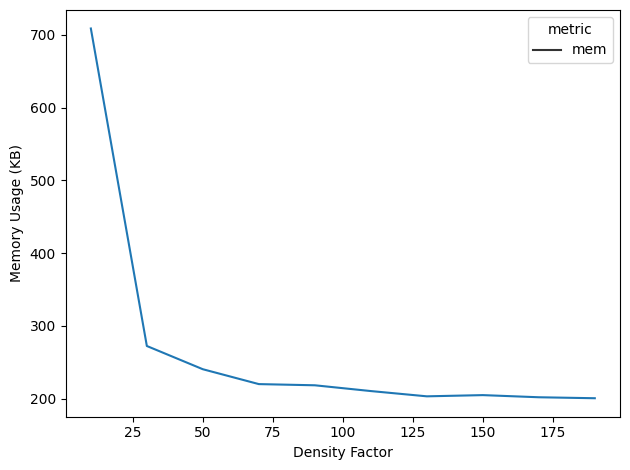

In [7]:
# memory

from numpy import percentile
import sys

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run, measure_mem


def measure_density_factor(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': 'mem', 'value': sys.getsizeof(db) / 1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': list(range(10, 201, 20)),
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_density_factor], {}
)


data = df[['density_factor', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['mem'])]

lineplot(data=data, x='density_factor', y='value', style='metric',
         filename='density_factor_mem.pdf', xlabel='Density Factor',
         ylabel='Memory Usage (KB)')

# keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, memtable_bytes_limit: 10K, 10 1-second samples for each average latency measurement


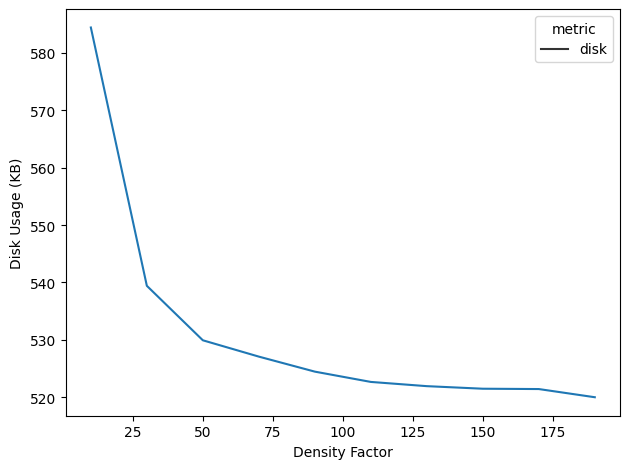

In [8]:
# disk

import sys
from numpy import percentile

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run, get_dir_size_bytes


def measure_density_factor(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': 'disk', 'value': get_dir_size_bytes(db.data_dir) / 1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': list(range(10, 201, 20)),
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_density_factor], {}
)


data = df[['density_factor', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['disk'])]

lineplot(data=data, x='density_factor', y='value', style='metric',
         filename='density_factor_disk.pdf', xlabel='Density Factor',
         ylabel='Disk Usage (KB)')


# keylen: 4, vlen: 4, nitems: 10_000, writing 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, memtable_bytes_limit: 10K, 10 1-second samples for each average latency measurement
